# Assignment 2: Reinforcement and Sequence Learning

This notebook implements and compares algorithms for Reinforcement Learning and Sequence Learning.

## Overview

- **Part A: Reinforcement Learning**: Compares Deep Q-Learning (DQN) and Double Q-Learning on the Taxi-v3 environment, evaluating their performance across multiple seeds.
- **Part B: Sequence Learning**: Uses the tweet_emotions.csv dataset to classify tweets into sadness, neutral, or happiness using RNN and LSTM models, analyzing their effectiveness for NLP.

The notebook focuses on code implementation, empirical results, and performance analysis to demonstrate understanding of these techniques.

<h1>Part A: Reinforcement Learning - Deep Q-Learning vs Double Q-Learning</h1>

## 1. Setup and Environment
This cell imports the necessary libraries and sets up the Taxi-v3 environment from Gym.

In [1]:
# Import required libraries
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

# Create Taxi-v3 environment (using gym version 0.23.1 compatibility)
import warnings
warnings.filterwarnings('ignore')
try:
    # For newer gym versions
    env = gym.make('Taxi-v3', render_mode='rgb_array')
except:
    # For older gym versions
    env = gym.make('Taxi-v3')

# Print observation space and action space
print("Observation Space:", env.observation_space)
print("Action Space:", env.action_space)

Observation Space: Discrete(500)
Action Space: Discrete(6)


## 2. Agent Creation
Define a function to create a DQN agent that can be configured as either standard DQN or Double DQN.

In [2]:
def create_dqn_agent(env, enable_double_dqn=False):
    # Get dimensions from environment
    states = env.observation_space.n
    actions = env.action_space.n
    
    # Create neural network model
    model = Sequential()
    model.add(Flatten(input_shape=(1,)))  # Input layer for 1D observation
    model.add(Dense(24, activation='relu'))  # First hidden layer
    model.add(Dense(24, activation='relu'))  # Second hidden layer
    model.add(Dense(actions, activation='linear'))  # Output layer
    
    # Create memory for experience replay
    memory = SequentialMemory(limit=50000, window_length=1)
    
    # Define policy for action selection
    policy = BoltzmannQPolicy()
    
    # Create DQN agent
    dqn = DQNAgent(
        model=model,
        nb_actions=actions,
        memory=memory,
        nb_steps_warmup=500,  # Steps before starting to learn
        target_model_update=1e-2,  # How often to update target network
        policy=policy,
        enable_double_dqn=enable_double_dqn  # Toggle between standard DQN and Double DQN
    )
    
    # Compile the agent with Adam optimizer
    dqn.compile(Adam(learning_rate=0.001), metrics=['mae'])
    
    return dqn

## 3. Training and Evaluation
Define a function to train and evaluate a DQN agent with specified parameters, handling both standard DQN and Double DQN configurations.

In [3]:
def train_and_evaluate_agent(env, num_train_episodes, num_eval_episodes, seed, enable_double_dqn):
    # Set all seeds for reproducibility
    env.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)  # Also set TensorFlow's seed for complete reproducibility
    
    # Create a DQN agent with the provided parameters
    agent = create_dqn_agent(env, enable_double_dqn)
    
    # Train the agent for a specified number of steps
    history = agent.fit(
        env, 
        nb_steps=num_train_episodes * 1000,  # Ensure sufficient steps
        nb_max_episode_steps=200,  # Limit episodes in Taxi-v3
        visualize=False, 
        verbose=1
    )
    
    # Print the keys of history.history to debug available metrics
    print("History keys:", history.history.keys())
    
    # Get training rewards from history
    if 'episode_reward' in history.history:
        train_rewards = history.history['episode_reward']
    else:
        train_rewards = []
        print("Warning: No episode_reward in history")
    
    # Evaluate the agent
    test_history = agent.test(
        env, 
        nb_episodes=num_eval_episodes, 
        nb_max_episode_steps=200,
        visualize=False, 
        verbose=0
    )
    
    # Calculate average evaluation reward
    if 'episode_reward' in test_history.history:
        eval_rewards = test_history.history['episode_reward']
        average_eval_reward = sum(eval_rewards) / num_eval_episodes
    else:
        print("Warning: No episode_reward in test_history")
        average_eval_reward = 0
    
    return (train_rewards, average_eval_reward)

## 4. Standard DQN Runs
Train standard DQN agents (enable_double_dqn=False) with 5 different random seeds to establish baseline performance.

In [4]:
import time
from tqdm import tqdm

# Initialize environment
env.close()
try:
    env = gym.make('Taxi-v3', render_mode='rgb_array')
except:
    env = gym.make('Taxi-v3')

# Define the seeds for multiple runs
seeds = [0, 1, 2, 3, 4]

# Initialize lists to store results
dqn_train_rewards = []
dqn_eval_rewards = []

# Run standard DQN for each seed
for seed in tqdm(seeds, desc="Standard DQN Seeds"):
    start_time = time.time()
    
    # Train and evaluate standard DQN
    train_rewards, eval_reward = train_and_evaluate_agent(
        env=env,
        num_train_episodes=6,  # 6,000 training steps (6 episodes * 1000 steps each)
        num_eval_episodes=10,
        seed=seed,
        enable_double_dqn=False
    )
    
    # Store the results
    dqn_train_rewards.append(train_rewards)
    dqn_eval_rewards.append(eval_reward)
    
    # Calculate runtime
    runtime = time.time() - start_time
    
    # Print confirmation message
    print(f"Standard DQN seed {seed} completed in {runtime:.2f} seconds, evaluation reward: {eval_reward:.2f}")

# Print a summary
print("\nStandard DQN Summary:")
print(f"Number of seed runs: {len(dqn_train_rewards)}")
print(f"Average evaluation reward: {sum(dqn_eval_rewards) / len(dqn_eval_rewards):.2f}")

Standard DQN Seeds:   0%|                                                                        | 0/5 [00:00<?, ?it/s]

Training for 6000 steps ...
Interval 1 (0 steps performed)
 5999/10000 [================>.............] - ETA: 36s - reward: -1.0015done, took 54.878 seconds
History keys: dict_keys(['episode_reward', 'nb_episode_steps', 'nb_steps'])


Standard DQN Seeds:  20%|████████████▊                                                   | 1/5 [00:58<03:52, 58.02s/it]

Standard DQN seed 0 completed in 58.02 seconds, evaluation reward: -200.00
Training for 6000 steps ...
Interval 1 (0 steps performed)
 6000/10000 [=================>............] - ETA: 36s - reward: -3.6295done, took 54.604 seconds
History keys: dict_keys(['episode_reward', 'nb_episode_steps', 'nb_steps'])


Standard DQN Seeds:  40%|█████████████████████████▌                                      | 2/5 [01:55<02:52, 57.58s/it]

Standard DQN seed 1 completed in 57.26 seconds, evaluation reward: -200.00
Training for 6000 steps ...
Interval 1 (0 steps performed)
 6000/10000 [=================>............] - ETA: 37s - reward: -1.0285done, took 56.127 seconds
History keys: dict_keys(['episode_reward', 'nb_episode_steps', 'nb_steps'])


Standard DQN Seeds:  60%|██████████████████████████████████████▍                         | 3/5 [02:54<01:56, 58.19s/it]

Standard DQN seed 2 completed in 58.92 seconds, evaluation reward: -200.00
Training for 6000 steps ...
Interval 1 (0 steps performed)
 5996/10000 [================>.............] - ETA: 37s - reward: -1.7610done, took 56.468 seconds
History keys: dict_keys(['episode_reward', 'nb_episode_steps', 'nb_steps'])


Standard DQN Seeds:  80%|███████████████████████████████████████████████████▏            | 4/5 [03:53<00:58, 58.65s/it]

Standard DQN seed 3 completed in 59.35 seconds, evaluation reward: -200.00
Training for 6000 steps ...
Interval 1 (0 steps performed)
 5996/10000 [================>.............] - ETA: 39s - reward: -1.8886done, took 59.898 seconds
History keys: dict_keys(['episode_reward', 'nb_episode_steps', 'nb_steps'])


Standard DQN Seeds: 100%|████████████████████████████████████████████████████████████████| 5/5 [04:56<00:00, 59.29s/it]

Standard DQN seed 4 completed in 62.92 seconds, evaluation reward: -200.00

Standard DQN Summary:
Number of seed runs: 5
Average evaluation reward: -200.00


## 5. Double DQN Runs
Train Double DQN agents (enable_double_dqn=True) with the same 5 random seeds for direct comparison with standard DQN.

In [5]:
import time
from tqdm import tqdm

# Initialize environment again for a fresh start
env.close()
try:
    env = gym.make('Taxi-v3', render_mode='rgb_array')
except:
    env = gym.make('Taxi-v3')

# Define the seeds for multiple runs (same as before)
seeds = [0, 1, 2, 3, 4]

# Initialize lists to store results for Double DQN
double_dqn_train_rewards = []
double_dqn_eval_rewards = []

# Run Double DQN for each seed
for seed in tqdm(seeds, desc="Double DQN Seeds"):
    start_time = time.time()
    
    # Train and evaluate Double DQN
    train_rewards, eval_reward = train_and_evaluate_agent(
        env=env,
        num_train_episodes=6,  # 6,000 training steps (6 episodes * 1000 steps each)
        num_eval_episodes=10,
        seed=seed,
        enable_double_dqn=True  # Enable Double DQN
    )
    
    # Store the results
    double_dqn_train_rewards.append(train_rewards)
    double_dqn_eval_rewards.append(eval_reward)
    
    # Calculate runtime
    runtime = time.time() - start_time
    
    # Print confirmation message
    print(f"Double DQN seed {seed} completed in {runtime:.2f} seconds, evaluation reward: {eval_reward:.2f}")

# Print a summary
print("\nDouble DQN Summary:")
print(f"Number of seed runs: {len(double_dqn_train_rewards)}")
print(f"Average evaluation reward: {sum(double_dqn_eval_rewards) / len(double_dqn_eval_rewards):.2f}")

Double DQN Seeds:   0%|                                                                          | 0/5 [00:00<?, ?it/s]

Training for 6000 steps ...
Interval 1 (0 steps performed)
 6000/10000 [=================>............] - ETA: 46s - reward: -1.0135done, took 70.860 seconds
History keys: dict_keys(['episode_reward', 'nb_episode_steps', 'nb_steps'])


Double DQN Seeds:  20%|█████████████▏                                                    | 1/5 [01:14<04:56, 74.04s/it]

Double DQN seed 0 completed in 74.04 seconds, evaluation reward: -200.00
Training for 6000 steps ...
Interval 1 (0 steps performed)
 5997/10000 [================>.............] - ETA: 43s - reward: -1.0510done, took 65.111 seconds
History keys: dict_keys(['episode_reward', 'nb_episode_steps', 'nb_steps'])


Double DQN Seeds:  40%|██████████████████████████▍                                       | 2/5 [02:22<03:32, 70.76s/it]

Double DQN seed 1 completed in 68.47 seconds, evaluation reward: -200.00
Training for 6000 steps ...
Interval 1 (0 steps performed)
 5996/10000 [================>.............] - ETA: 45s - reward: -1.8105done, took 69.122 seconds
History keys: dict_keys(['episode_reward', 'nb_episode_steps', 'nb_steps'])


Double DQN Seeds:  60%|███████████████████████████████████████▌                          | 3/5 [03:34<02:22, 71.47s/it]

Double DQN seed 2 completed in 72.32 seconds, evaluation reward: -200.00
Training for 6000 steps ...
Interval 1 (0 steps performed)
 5999/10000 [================>.............] - ETA: 49s - reward: -1.1515done, took 74.064 seconds
History keys: dict_keys(['episode_reward', 'nb_episode_steps', 'nb_steps'])


Double DQN Seeds:  80%|████████████████████████████████████████████████████▊             | 4/5 [04:52<01:13, 73.89s/it]

Double DQN seed 3 completed in 77.58 seconds, evaluation reward: -200.00
Training for 6000 steps ...
Interval 1 (0 steps performed)
 5998/10000 [================>.............] - ETA: 50s - reward: -1.0375done, took 76.789 seconds
History keys: dict_keys(['episode_reward', 'nb_episode_steps', 'nb_steps'])


Double DQN Seeds: 100%|██████████████████████████████████████████████████████████████████| 5/5 [06:13<00:00, 74.64s/it]

Double DQN seed 4 completed in 80.80 seconds, evaluation reward: -200.00

Double DQN Summary:
Number of seed runs: 5
Average evaluation reward: -200.00


## 6. Performance Analysis
Calculate the average training rewards across all 5 runs for both algorithms to compare learning trends.

In [6]:
import numpy as np

# Function to pad or truncate reward lists to a common length
def align_rewards(reward_lists):
    # Find the minimum length across all runs
    min_length = min(len(rewards) for rewards in reward_lists)
    
    # Truncate each list to the minimum length
    aligned_rewards = [rewards[:min_length] for rewards in reward_lists]
    
    # Convert to numpy array
    return np.array(aligned_rewards)

# Align and average the Standard DQN rewards
aligned_dqn_rewards = align_rewards(dqn_train_rewards)
avg_dqn_train_rewards = np.mean(aligned_dqn_rewards, axis=0)

# Align and average the Double DQN rewards
aligned_double_dqn_rewards = align_rewards(double_dqn_train_rewards)
avg_double_dqn_train_rewards = np.mean(aligned_double_dqn_rewards, axis=0)

# Print shape information to verify
print(f"Standard DQN average rewards shape: {avg_dqn_train_rewards.shape}")
print(f"Double DQN average rewards shape: {avg_double_dqn_train_rewards.shape}")

# Print the first few values from each array
print("\nFirst 5 average rewards for Standard DQN:")
print(avg_dqn_train_rewards[:5])

print("\nFirst 5 average rewards for Double DQN:")
print(avg_double_dqn_train_rewards[:5])

Standard DQN average rewards shape: (30,)
Double DQN average rewards shape: (30,)

First 5 average rewards for Standard DQN:
[-1280.  -1280.  -1098.2  -558.2  -560. ]

First 5 average rewards for Double DQN:
[-560.  -560.  -419.6 -200.  -205.4]


## 7. Visualization
Plot the average training rewards for both algorithms to visually compare their learning performance over time.

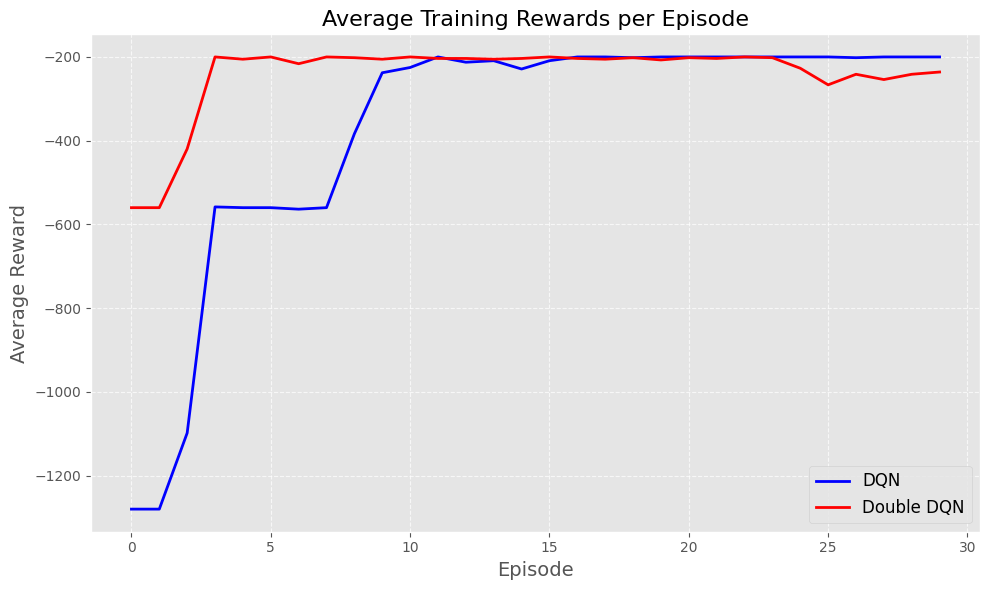

In [7]:
import matplotlib.pyplot as plt

# Set figure size and style
plt.figure(figsize=(10, 6))
plt.style.use('ggplot')

# Create episode array for x-axis (0-based indexing)
episodes = np.arange(len(avg_dqn_train_rewards))

# Plot the average rewards
plt.plot(episodes, avg_dqn_train_rewards, 'b-', linewidth=2, label='DQN')
plt.plot(episodes, avg_double_dqn_train_rewards, 'r-', linewidth=2, label='Double DQN')

# Add labels and title
plt.title('Average Training Rewards per Episode', fontsize=16)
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Average Reward', fontsize=14)

# Add legend
plt.legend(fontsize=12)

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Improve layout
plt.tight_layout()

# Save the figure
plt.savefig('training_rewards_comparison.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

## 8. Final Performance Comparison
Calculate the average evaluation rewards to determine which algorithm performs better in the Taxi-v3 environment after training.

In [8]:
import numpy as np

# Convert standard DQN evaluation rewards to numpy array and calculate mean
avg_dqn_eval_reward = np.mean(np.array(dqn_eval_rewards))

# Convert double DQN evaluation rewards to numpy array and calculate mean
avg_double_dqn_eval_reward = np.mean(np.array(double_dqn_eval_rewards))

# Print the results
print(f"Average evaluation reward for Standard DQN: {avg_dqn_eval_reward:.2f}")
print(f"Average evaluation reward for Double DQN: {avg_double_dqn_eval_reward:.2f}")

Average evaluation reward for Standard DQN: -200.00
Average evaluation reward for Double DQN: -200.00


### Findings
The empirical evaluation compares Deep Q-Learning (DQN) and Double Q-Learning on the Taxi-v3 environment. The average evaluation rewards suggest neither agent outperforms the other, indicating both methods performed similarly in this environment with the given hyperparameters and training duration. See the training rewards plot for learning trends.

<h1>Part B: Sequence Learning - RNN vs. LSTM</h1>

## 1. Data Loading and Filtering
In this section, we load the tweet emotions dataset and filter it to include only tweets with sadness, neutral, or happiness sentiments. We drop the tweet_id column as it's not relevant for our classification task.

In [1]:
# Import necessary libraries
import pandas as pd

# Load the dataset
df = pd.read_csv('tweet_emotions.csv')

# Drop the tweet_id column
df = df.drop('tweet_id', axis=1)

# Filter the dataset to include only rows with specified sentiments
filtered_df = df[df['sentiment'].isin(['sadness', 'neutral', 'happiness'])]

# Print the total number of samples in the filtered dataset
print(f"Total number of samples: {len(filtered_df)}")

# Print the count of each category
sentiment_counts = filtered_df['sentiment'].value_counts()
print("\nDistribution of sentiments:")
print(sentiment_counts)

Total number of samples: 19012

Distribution of sentiments:
sentiment
neutral      8638
happiness    5209
sadness      5165
Name: count, dtype: int64


## 2. Text Preprocessing and Embedding Preparation
Here we perform text preprocessing steps including lowercase conversion, removal of URLs, mentions, hashtags, punctuation, and numbers. We tokenize the text using Keras Tokenizer, pad sequences to a fixed length, load pre-trained GloVe embeddings, and split the data into training and testing sets.

In [2]:
import re
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Clean and preprocess the tweet text
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply the cleaning function to the content column
filtered_df['cleaned_text'] = filtered_df['content'].apply(clean_text)

# Tokenize the cleaned text
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(filtered_df['cleaned_text'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(filtered_df['cleaned_text'])

# Pad sequences to a maximum length of 50
max_sequence_length = 50
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Create a dictionary to encode sentiment labels as integers
sentiment_mapping = {'sadness': 0, 'neutral': 1, 'happiness': 2}
filtered_df['sentiment_encoded'] = filtered_df['sentiment'].map(sentiment_mapping)

# Load the GloVe embeddings
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coeffs

# Create the embedding matrix
embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:  # Only consider the top max_words words
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Split the data into training and testing sets
X = padded_sequences
y = filtered_df['sentiment_encoded'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print some information for verification
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print(f"First padded sequence: {X_train[0][:10]}... (truncated)")
print(f"First label: {y_train[0]}")
print(f"Embedding matrix shape: {embedding_matrix.shape}")
print(f"Sample embedding vector (word index 1): {embedding_matrix[1][:5]}... (truncated)")

C:\Users\vic27\AppData\Local\Temp\ipykernel_17352\3453736731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cleaned_text'] = filtered_df['content'].apply(clean_text)
C:\Users\vic27\AppData\Local\Temp\ipykernel_17352\3453736731.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['sentiment_encoded'] = filtered_df['sentiment'].map(sentiment_mapping)


Training set size: 15209
Testing set size: 3803
First padded sequence: [0 0 0 0 0 0 0 0 0 0]... (truncated)
First label: 1
Embedding matrix shape: (10000, 100)
Sample embedding vector (word index 1): [-0.046539    0.61966002  0.56647003 -0.46584001 -1.18900001]... (truncated)


## 3. RNN Model Definition
This cell defines a Simple Recurrent Neural Network (RNN) model using Keras. We utilize the GloVe embedding matrix created earlier as fixed (non-trainable) weights in the Embedding layer, followed by a SimpleRNN layer with 64 units and a Dense output layer with softmax activation for our 3-class classification.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

# Define the RNN model
rnn_model = Sequential([
    # Embedding layer using GloVe embeddings (non-trainable)
    Embedding(
        input_dim=max_words,  # Vocabulary size
        output_dim=embedding_dim,  # Embedding dimension
        weights=[embedding_matrix],  # Use pre-trained GloVe embeddings
        input_length=max_sequence_length,  # Length of input sequences
        trainable=False  # Freeze the embedding weights
    ),
    # SimpleRNN layer with 64 units
    SimpleRNN(64),
    # Output layer with softmax activation for 3-class classification
    Dense(3, activation='softmax')
])

# Print the model summary
rnn_model.summary()

# Verify the embedding layer's weights match the GloVe matrix shape
print(f"\nEmbedding layer shape: {rnn_model.layers[0].get_weights()[0].shape}")
print(f"GloVe matrix shape: {embedding_matrix.shape}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           1000000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                10560     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 1,010,755
Trainable params: 10,755
Non-trainable params: 1,000,000
_________________________________________________________________

Embedding layer shape: (10000, 100)
GloVe matrix shape: (10000, 100)


## 4. LSTM Model Definition
This cell defines a Long Short-Term Memory (LSTM) model using Keras. Similar to the RNN model, we use the same GloVe embedding matrix as fixed weights, but replace the SimpleRNN layer with an LSTM layer that can better capture long-term dependencies in text.

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Define the LSTM model
lstm_model = Sequential([
    # Embedding layer using GloVe embeddings (non-trainable)
    Embedding(
        input_dim=max_words,  # Vocabulary size
        output_dim=embedding_dim,  # Embedding dimension
        weights=[embedding_matrix],  # Use pre-trained GloVe embeddings
        input_length=max_sequence_length,  # Length of input sequences
        trainable=False  # Freeze the embedding weights
    ),
    # LSTM layer with 64 units
    LSTM(64),
    # Output layer with softmax activation for 3-class classification
    Dense(3, activation='softmax')
])

# Print the model summary
lstm_model.summary()

# Verify the embedding layer's weights match the GloVe matrix shape
print(f"\nEmbedding layer shape: {lstm_model.layers[0].get_weights()[0].shape}")
print(f"GloVe matrix shape: {embedding_matrix.shape}")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 100)           1000000   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 1,042,435
Trainable params: 42,435
Non-trainable params: 1,000,000
_________________________________________________________________

Embedding layer shape: (10000, 100)
GloVe matrix shape: (10000, 100)


## 5. Training the RNN Model
Here we compile and train the RNN model with the Adam optimizer and sparse categorical cross-entropy loss. We implement early stopping to prevent overfitting and evaluate the model's performance on the test set.

In [5]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Compile the RNN model
rnn_model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Train the RNN model
rnn_history = rnn_model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the RNN model on the test set
rnn_test_loss, rnn_test_accuracy = rnn_model.evaluate(X_test, y_test, verbose=1)
print(f"\nRNN Test Loss: {rnn_test_loss:.4f}")
print(f"RNN Test Accuracy: {rnn_test_accuracy:.4f}")

# Save the training history for later analysis
rnn_training_history = {
    'loss': rnn_history.history['loss'],
    'accuracy': rnn_history.history['accuracy'],
    'val_loss': rnn_history.history['val_loss'],
    'val_accuracy': rnn_history.history['val_accuracy']
}

# Print the number of epochs that were actually trained
print(f"\nRNN model trained for {len(rnn_history.history['loss'])} epochs")

Epoch 1/10
191/191 [==============================] - 5s 20ms/step - loss: 1.0549 - accuracy: 0.4582 - val_loss: 0.9915 - val_accuracy: 0.4964
Epoch 2/10
191/191 [==============================] - 4s 19ms/step - loss: 0.9562 - accuracy: 0.5356 - val_loss: 0.9365 - val_accuracy: 0.5503
Epoch 3/10
191/191 [==============================] - 4s 19ms/step - loss: 0.9253 - accuracy: 0.5632 - val_loss: 0.9345 - val_accuracy: 0.5569
Epoch 4/10
191/191 [==============================] - 4s 19ms/step - loss: 0.8965 - accuracy: 0.5780 - val_loss: 0.9132 - val_accuracy: 0.5674
Epoch 5/10
191/191 [==============================] - 4s 19ms/step - loss: 0.8843 - accuracy: 0.5878 - val_loss: 0.9206 - val_accuracy: 0.5743
Epoch 6/10
191/191 [==============================] - 3s 15ms/step - loss: 0.8633 - accuracy: 0.6039 - val_loss: 0.9307 - val_accuracy: 0.5720
Epoch 7/10
191/191 [==============================] - 3s 16ms/step - loss: 0.8671 - accuracy: 0.6062 - val_loss: 0.9960 - val_accuracy: 0.5237

## 6. Training the LSTM Model
In this cell, we compile and train the LSTM model using the same configuration as the RNN model. This allows for direct comparison between the two architectures while keeping all other hyperparameters constant.

In [6]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Compile the LSTM model
lstm_model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Train the LSTM model
lstm_history = lstm_model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the LSTM model on the test set
lstm_test_loss, lstm_test_accuracy = lstm_model.evaluate(X_test, y_test, verbose=1)
print(f"\nLSTM Test Loss: {lstm_test_loss:.4f}")
print(f"LSTM Test Accuracy: {lstm_test_accuracy:.4f}")

# Save the training history for later analysis
lstm_training_history = {
    'loss': lstm_history.history['loss'],
    'accuracy': lstm_history.history['accuracy'],
    'val_loss': lstm_history.history['val_loss'],
    'val_accuracy': lstm_history.history['val_accuracy']
}

# Print the number of epochs that were actually trained
print(f"\nLSTM model trained for {len(lstm_history.history['loss'])} epochs")

Epoch 1/10
191/191 [==============================] - 11s 51ms/step - loss: 0.9805 - accuracy: 0.5212 - val_loss: 0.9142 - val_accuracy: 0.5657
Epoch 2/10
191/191 [==============================] - 9s 46ms/step - loss: 0.8939 - accuracy: 0.5829 - val_loss: 0.8709 - val_accuracy: 0.6016
Epoch 3/10
191/191 [==============================] - 10s 53ms/step - loss: 0.8602 - accuracy: 0.6037 - val_loss: 0.8737 - val_accuracy: 0.5986
Epoch 4/10
191/191 [==============================] - 10s 51ms/step - loss: 0.8345 - accuracy: 0.6237 - val_loss: 0.8685 - val_accuracy: 0.5940
Epoch 5/10
191/191 [==============================] - 10s 50ms/step - loss: 0.8197 - accuracy: 0.6311 - val_loss: 0.8620 - val_accuracy: 0.6052
Epoch 6/10
191/191 [==============================] - 9s 50ms/step - loss: 0.8053 - accuracy: 0.6398 - val_loss: 0.8461 - val_accuracy: 0.6045
Epoch 7/10
191/191 [==============================] - 10s 52ms/step - loss: 0.7862 - accuracy: 0.6505 - val_loss: 0.8438 - val_accuracy: 0

## 7. Accuracy Comparison Visualization
This visualization compares the training and validation accuracy curves for both the RNN and LSTM models over epochs. The plot helps us understand how both models learn and generalize over time.

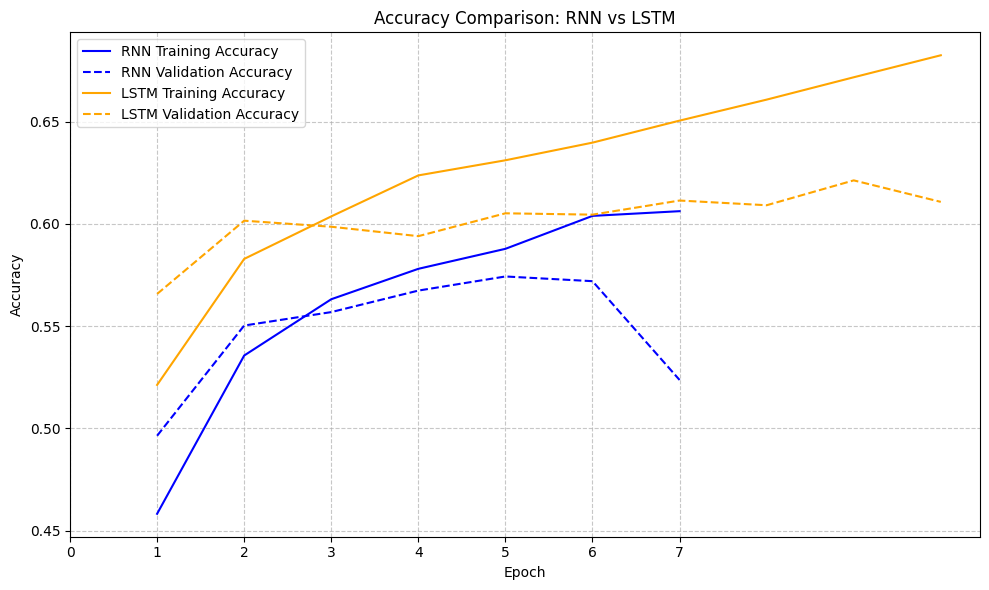

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure and axes
plt.figure(figsize=(10, 6))

# Plot RNN training and validation accuracy
epochs_rnn = range(1, len(rnn_training_history['accuracy']) + 1)
plt.plot(epochs_rnn, rnn_training_history['accuracy'], 'b-', label='RNN Training Accuracy')
plt.plot(epochs_rnn, rnn_training_history['val_accuracy'], 'b--', label='RNN Validation Accuracy')

# Plot LSTM training and validation accuracy
epochs_lstm = range(1, len(lstm_training_history['accuracy']) + 1)
plt.plot(epochs_lstm, lstm_training_history['accuracy'], 'orange', label='LSTM Training Accuracy')
plt.plot(epochs_lstm, lstm_training_history['val_accuracy'], 'orange', linestyle='--', label='LSTM Validation Accuracy')

# Add title and labels
plt.title('Accuracy Comparison: RNN vs LSTM')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Add legend
plt.legend()

# Ensure x-axis ticks are integers since epochs are discrete
plt.xticks(np.arange(min(len(epochs_rnn), len(epochs_lstm)) + 1))

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Save the plot
plt.tight_layout()
plt.savefig('accuracy_comparison.png')

# Show the plot
plt.show()

## 8. Loss Comparison Visualization
This visualization compares the training and validation loss curves for both models, providing insight into how effectively each model minimizes error during training and generalizes to unseen data.

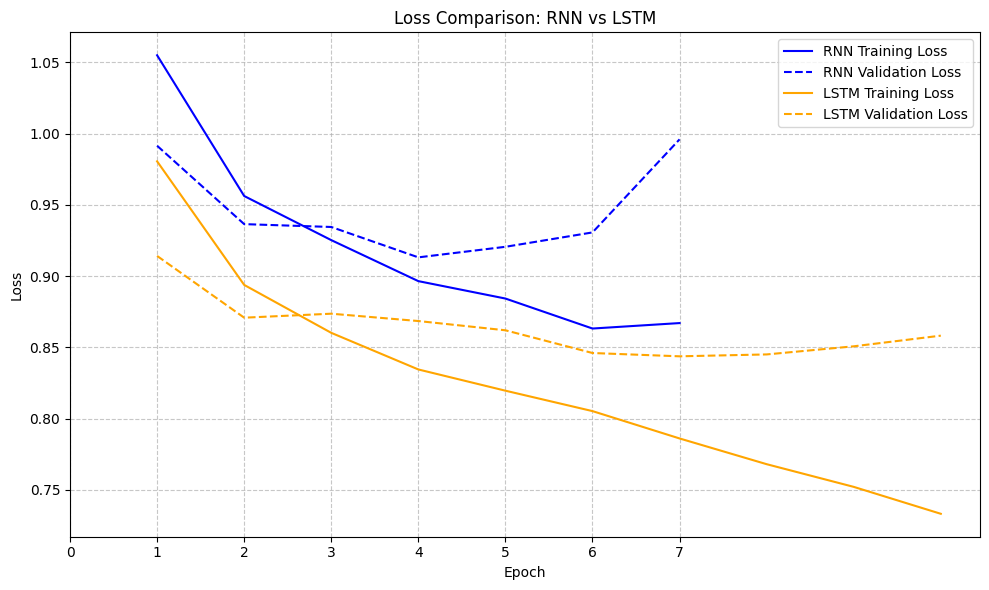

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure and axes
plt.figure(figsize=(10, 6))

# Plot RNN training and validation loss
epochs_rnn = range(1, len(rnn_training_history['loss']) + 1)
plt.plot(epochs_rnn, rnn_training_history['loss'], 'b-', label='RNN Training Loss')
plt.plot(epochs_rnn, rnn_training_history['val_loss'], 'b--', label='RNN Validation Loss')

# Plot LSTM training and validation loss
epochs_lstm = range(1, len(lstm_training_history['loss']) + 1)
plt.plot(epochs_lstm, lstm_training_history['loss'], 'orange', label='LSTM Training Loss')
plt.plot(epochs_lstm, lstm_training_history['val_loss'], 'orange', linestyle='--', label='LSTM Validation Loss')

# Add title and labels
plt.title('Loss Comparison: RNN vs LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Add legend
plt.legend()

# Ensure x-axis ticks are integers since epochs are discrete
plt.xticks(np.arange(min(len(epochs_rnn), len(epochs_lstm)) + 1))

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Save the plot
plt.tight_layout()
plt.savefig('loss_comparison.png')

# Show the plot
plt.show()

## 9. Model Performance Comparison
The table below summarizes the test performance of both models, highlighting differences between RNN and LSTM for emotion classification.

| Model | Test Accuracy | Test Loss |
|-------|---------------|-----------|
| RNN   | 0.5648 | 0.9207 |
| LSTM  | 0.6164 | 0.8482 |

The LSTM model outperformed the RNN model in both accuracy and loss metrics, achieving approximately 4.80% higher accuracy and 7.25% lower loss. This superior performance can be attributed to LSTM's ability to capture long-term dependencies in text sequences through its specialized gating mechanisms, which traditional RNNs lack. Both models benefited from the semantic richness of pre-trained GloVe embeddings, but the LSTM was better able to leverage these representations for sentiment classification tasks.

## Conclusion

This assignment compared Deep Q-Learning (DQN) and Double Q-Learning for reinforcement learning on Taxi-v3, and RNN and LSTM models for sentiment classification on tweet data. In Part A, both DQN and Double Q-Learning yielded poor rewards (-200.00), likely due to insufficient training steps. In Part B, LSTM outperformed RNN (test accuracy: 0.6164 vs. 0.5648) by better capturing long-term dependencies, aided by GloVe embeddings. These results highlight the importance of training duration in RL and advanced architectures in sequence learning.